In [ ]:
!pip install roboflow
!pip install supervision -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
import os
import re
import shutil
import torch
import supervision as sv
import random
import numpy as np
import cv2
import time

from roboflow import Roboflow
from PIL import Image
from tqdm import tqdm

In [ ]:
rf = Roboflow(api_key="mEEb3CsTmEQeVxuWO7pL")
project = rf.workspace("k-g0j45").project("heart-ppz4l")
version = project.version(4)
dataset = version.download("sam2")

# rename dataset.location to "data"
os.rename(dataset.location, "/content/data")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to heart-4 in sam2:: 100%|██████████| 689/689 [00:00<00:00, 5602.71it/s]


In [ ]:


# setup sam for training
!git clone https://github.com/facebookresearch/sam2.git
!wget -O /content/sam2/sam2/configs/train.yaml 'https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3'
%cd ./sam2/
!pip install -e .[dev] -q
!cd ./checkpoints && ./download_ckpts.sh


In [ ]:
# Script to rename roboflow filenames to something SAM 2.1 compatible.
FOLDER = "/content/data/train"

for filename in os.listdir(FOLDER):
    # Replace all except last dot with underscore
    new_filename = filename.replace(".", "_", filename.count(".") - 1)
    if not re.search(r"_\d+\.\w+$", new_filename):
        # Add an int to the end of base name
        new_filename = new_filename.replace(".", "_1.")
    os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))

In [ ]:
# train sam adjust hyperparameters in train.yml
!python training/train.py -c 'configs/train.yaml' --use-cluster 0 --num-gpus 1

###################### Train App Config ####################
scratch:
  resolution: 1024
  train_batch_size: 4
  num_train_workers: 10
  num_frames: 1
  max_num_objects: 1
  base_lr: 5.0e-06
  vision_lr: 3.0e-06
  phases_per_epoch: 1
  num_epochs: 20
dataset:
  img_folder: /content/data/train
  gt_folder: /content/data/train
  multiplier: 2
vos:
  train_transforms:
  - _target_: training.dataset.transforms.ComposeAPI
    transforms:
    - _target_: training.dataset.transforms.RandomHorizontalFlip
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomAffine
      degrees: 25
      shear: 20
      image_interpolation: bilinear
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomResizeAPI
      sizes: ${scratch.resolution}
      square: true
      consistent_transform: true
    - _target_: training.dataset.transforms.ColorJitter
      consistent_transform: true
      brightness: 0.1
      contrast: 0.03
      saturation: 0.03
   

In [ ]:
# saved sam2 github and finetunned model
src_folder = "/content/drive/MyDrive/sam2"
dst_folder = "/content/sam2"

print("Copying files to local storage...")
shutil.copytree(src_folder, dst_folder)
print("Copy complete!")


%cd ./sam2/
%ls

!pip install -e .[dev] -q

import sys
sys.path.append("/content/sam2")  # Add the outer `sam2` folder
sys.path.append("/content/sam2/sam2")  # Add the inner `sam2` folder


Copying files to local storage...
Copy complete!
/content/sam2
assets/             demo/                MANIFEST.in       sam2/            tools/
backend.Dockerfile  docker-compose.yaml  notebooks/        SAM_2.egg-info/  training/
checkpoints/        INSTALL.md           pyproject.toml    sam2_logs/
CODE_OF_CONDUCT.md  LICENSE              README.md         sav_dataset/
CONTRIBUTING.md     LICENSE_cctorch      RELEASE_NOTES.md  setup.py
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor



# use bfloat16 for the entire notebook
# from Meta notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

checkpoint = "/content/sam2/sam2_logs/configs/train.yaml/checkpoints/checkpoint.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2)

predictor = SAM2ImagePredictor(sam2)




checkpoint_base = "/content/sam2/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg_base = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2_base = build_sam2(model_cfg_base, checkpoint_base, device="cuda")
mask_generator_base = SAM2AutomaticMaskGenerator(sam2_base)

predictor_base = SAM2ImagePredictor(sam2_base)



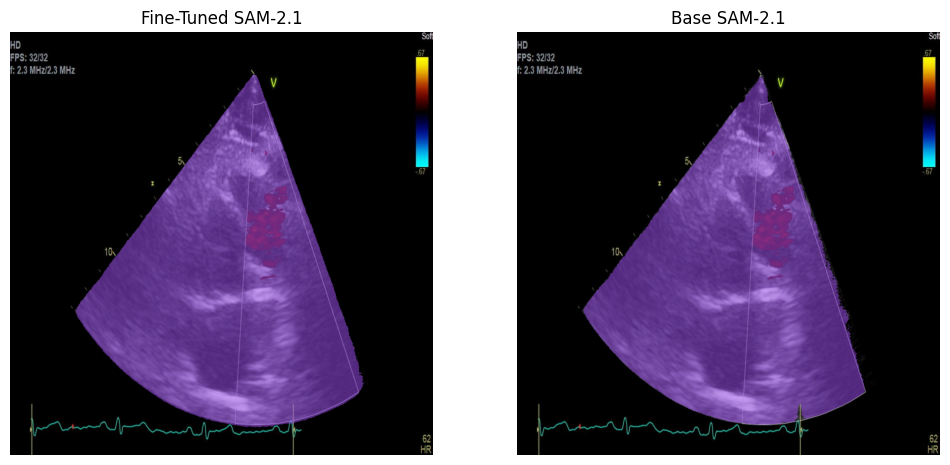

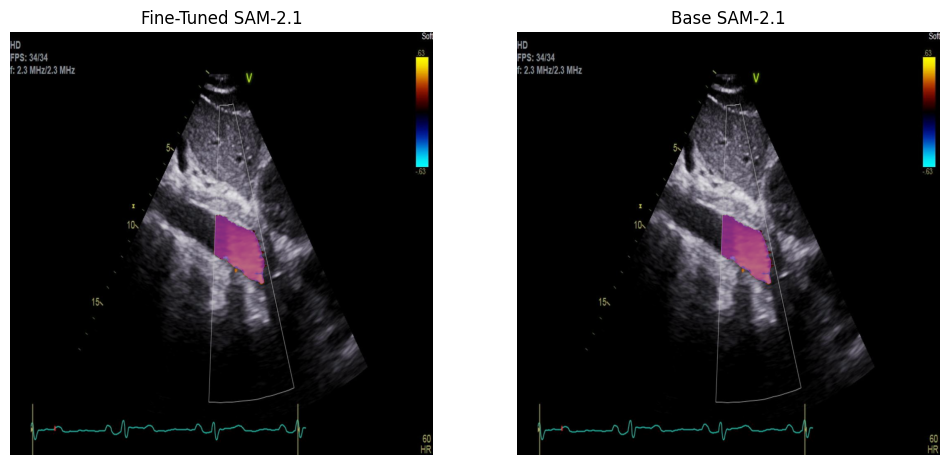

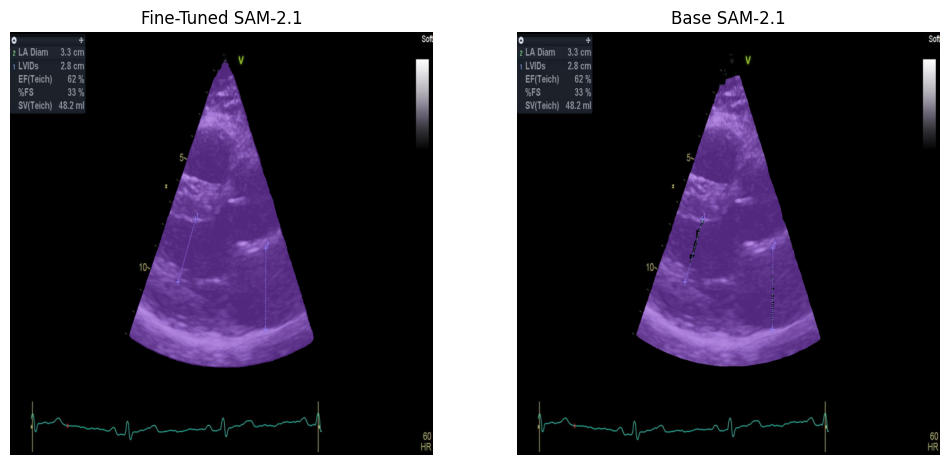

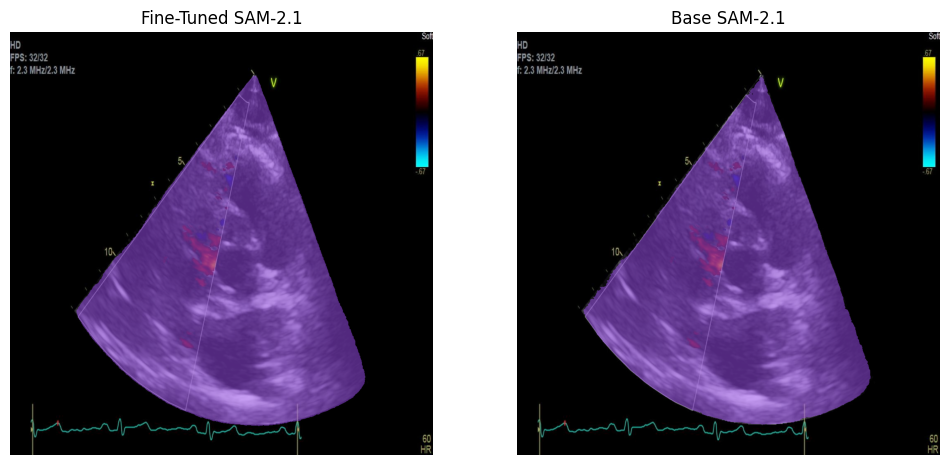

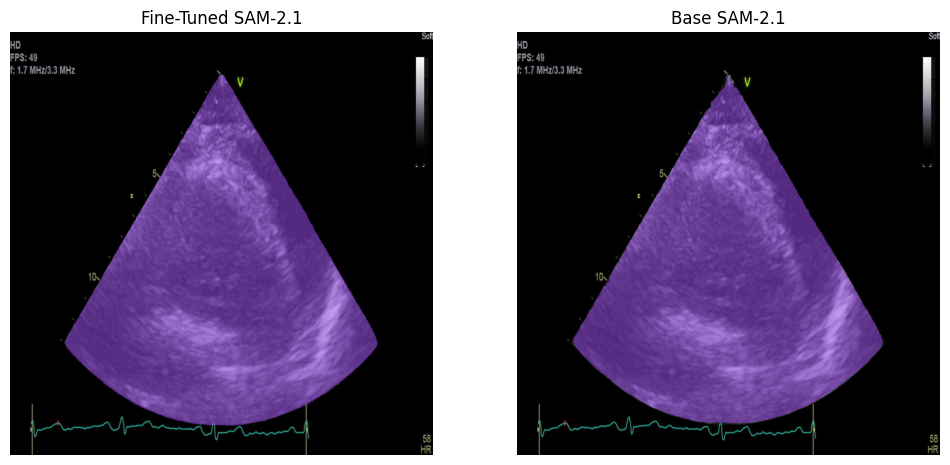

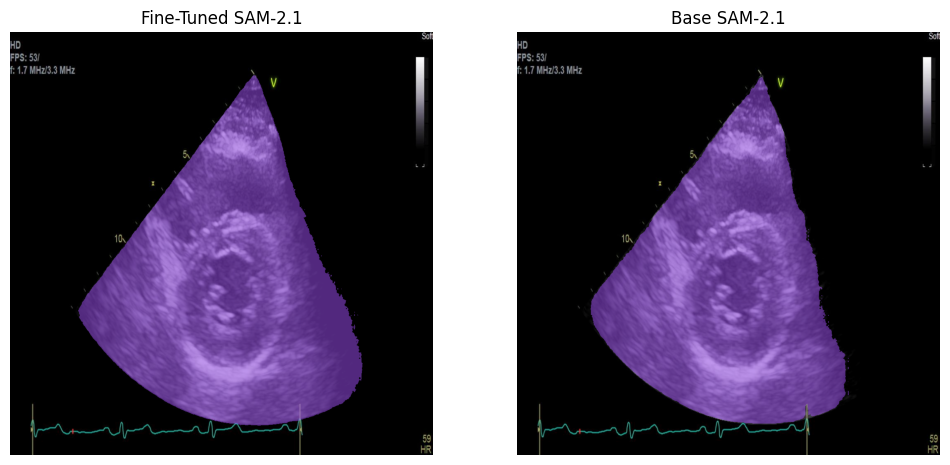

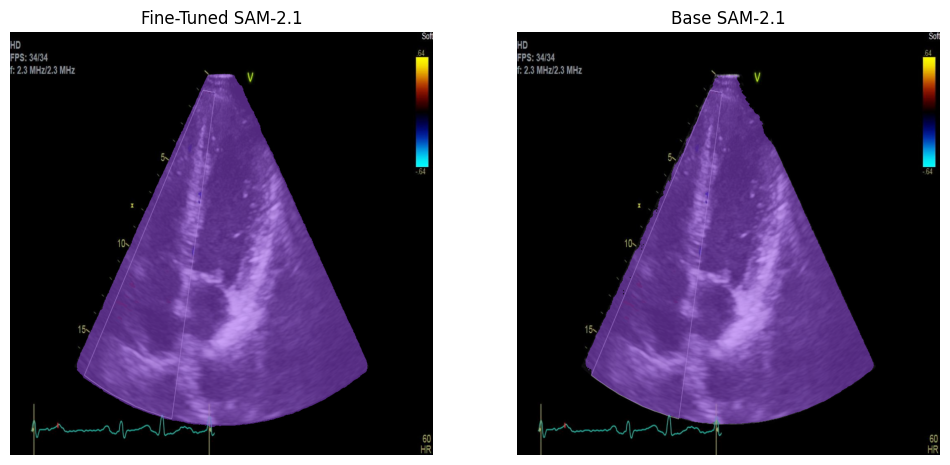

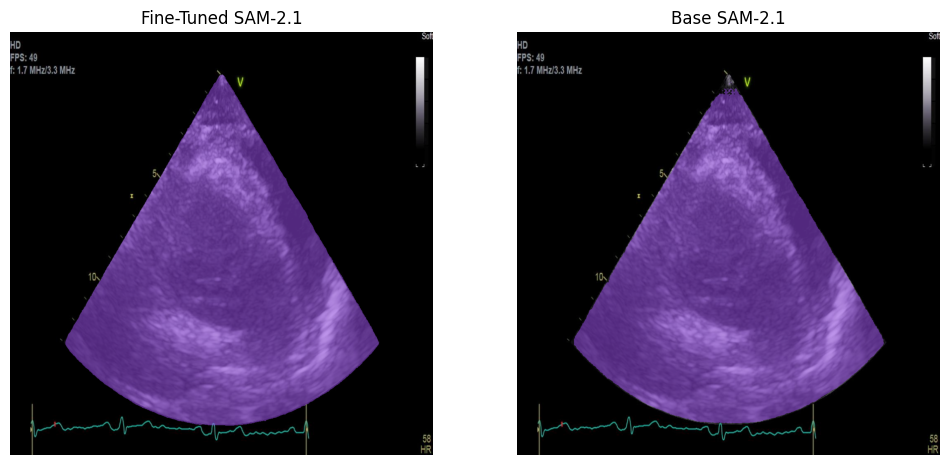

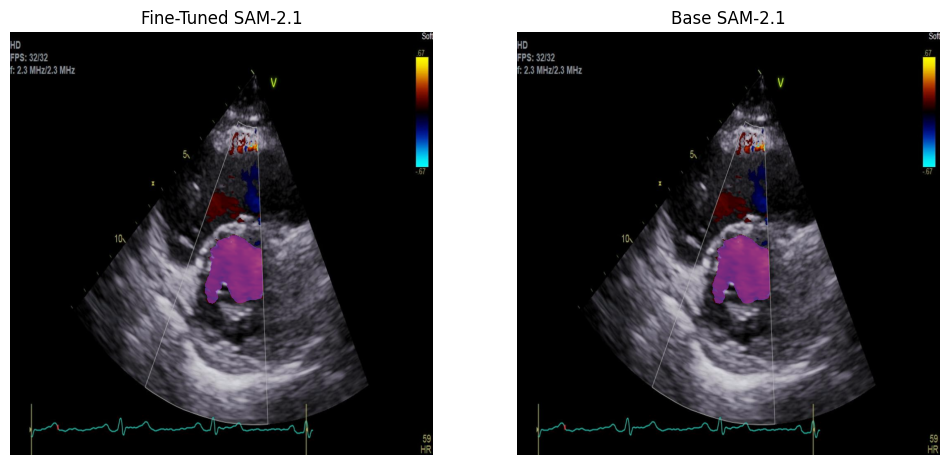

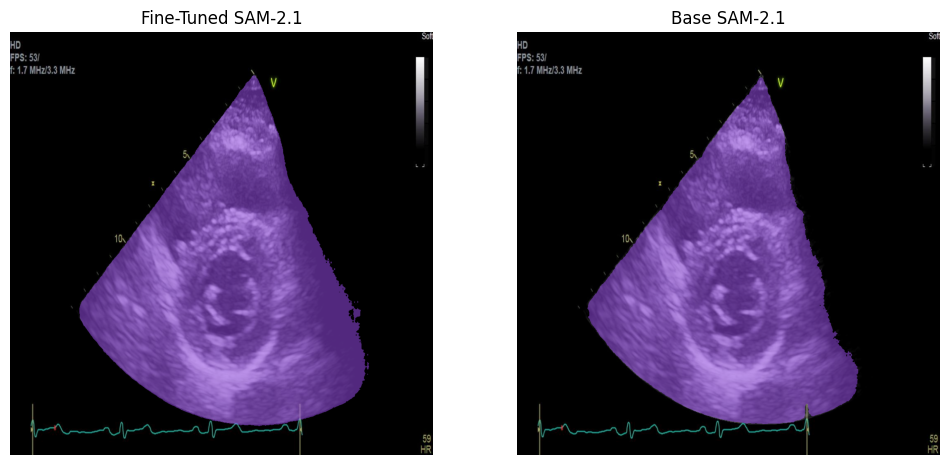

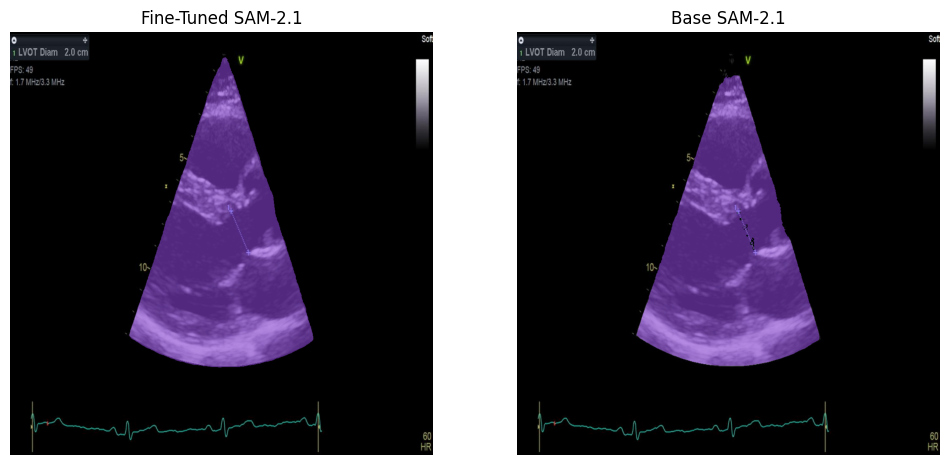

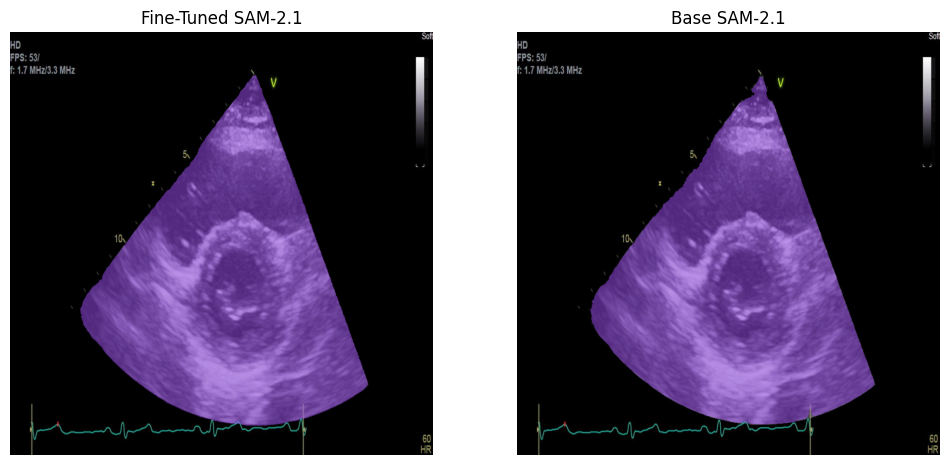

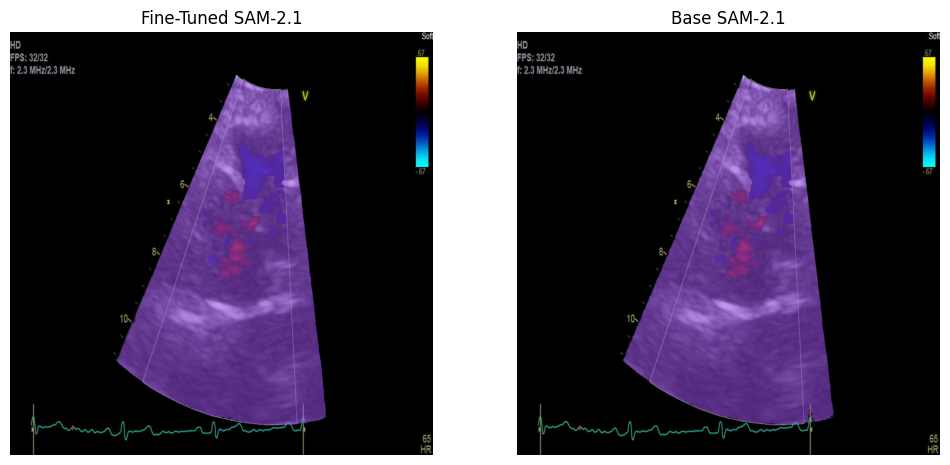

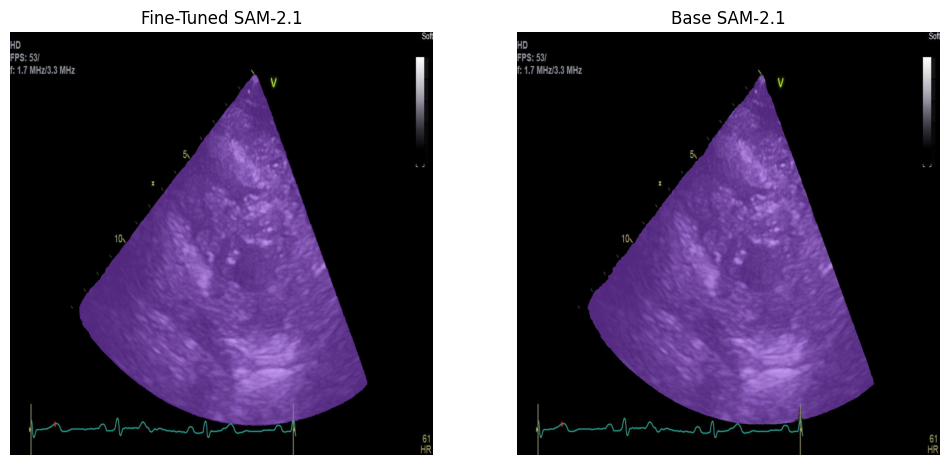

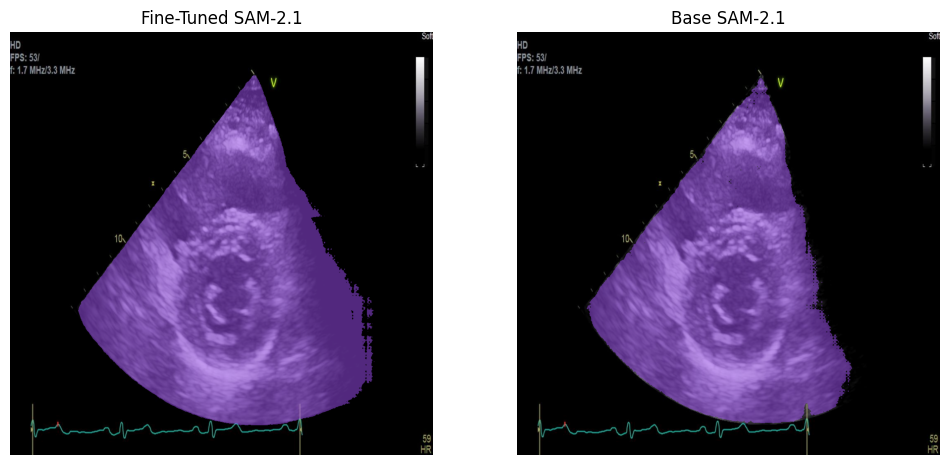

In [ ]:
# Path to validation set
validation_set_path = "/content/data/valid"

# Get all image file paths with .jpg extension
validation_images = [os.path.join(validation_set_path, img) for img in os.listdir(validation_set_path) if img.endswith(".jpg")]
input_point = np.array([[512, 512]])
input_label = np.array([1])

# Loop through all validation images
for image_path in validation_images:
    # Open the image
    opened_image = np.array(Image.open(image_path).convert("RGB"))

    # Generate results with fine-tuned SAM
    #result = mask_generator.generate(opened_image)
    predictor.set_image(opened_image)
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    # Create SAM results in the correct format
    sam_result = [
        {
            'segmentation': masks[i].astype(bool),
            'area': np.sum(masks[i]),
            'bbox': [0, 0, masks[i].shape[1], masks[i].shape[0]]  # default bbox
        } for i in range(masks.shape[0])
    ]

    detections = sv.Detections.from_sam(sam_result=sam_result)
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    annotated_image = mask_annotator.annotate(opened_image.copy(), detections=detections)

    # Generate results with base SAM
    #base_result = mask_generator_base.generate(opened_image)
    predictor_base.set_image(opened_image)
    masks_base, scores_base, _ = predictor_base.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    # Create SAM results in the correct format
    sam_result_base = [
        {
            'segmentation': masks_base[i].astype(bool),
            'area': np.sum(masks_base[i]),
            'bbox': [0, 0, masks_base[i].shape[1], masks_base[i].shape[0]]  # default bbox
        } for i in range(masks_base.shape[0])
    ]
    base_detections = sv.Detections.from_sam(sam_result=sam_result_base)
    base_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    base_annotated_image = base_annotator.annotate(opened_image.copy(), detections=base_detections)

    # Plot images side by side for comparison
    sv.plot_images_grid(
        images=[annotated_image, base_annotated_image],
        titles=["Fine-Tuned SAM-2.1", "Base SAM-2.1"],
        grid_size=(1, 2)
    )

In [ ]:
import cv2
from tqdm import tqdm
import time

# Path to validation set
validation_set_path = "/content/drive/MyDrive/grayson-2/p10159588/s99094419/processed_resized"
masked_output = "/content/drive/MyDrive/grayson-2/p10159588/s99094419/masked"
# Get all image file paths with .jpg extension
validation_images = [os.path.join(validation_set_path, img) for img in os.listdir(validation_set_path) if img.endswith(".jpg")]
input_point = np.array([[512, 512]])
input_label = np.array([1])

# Initialize progress bar
total_images = len(validation_images)
start_time = time.time()

# Loop through all validation images with tqdm progress bar
with tqdm(total=total_images, desc="Processing Images", unit="image") as pbar:
    for idx, image_path in enumerate(validation_images):
        # Open the image
        opened_image = np.array(Image.open(image_path).convert("RGB"))

        # Generate results with fine-tuned SAM
        predictor.set_image(opened_image)
        masks, scores, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,
        )

        # Process each mask
        for i, mask in enumerate(masks):
            # Convert mask to binary format
            binary_mask = mask.astype(np.uint8) * 255

            # Apply the mask to the image
            masked_image = cv2.bitwise_and(opened_image, opened_image, mask=binary_mask)

            # Save the masked image
            masked_image_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_masked_{i}.jpg"
            masked_image_path = os.path.join(masked_output, masked_image_filename)
            Image.fromarray(masked_image).save(masked_image_path)

        # Update progress bar and calculate ETA
        elapsed_time = time.time() - start_time
        avg_time_per_image = elapsed_time / (idx + 1)  # Average time per processed image
        remaining_images = total_images - (idx + 1)
        estimated_time_left = avg_time_per_image * remaining_images
        pbar.set_postfix(ETA=f"{estimated_time_left / 60:.2f} min")
        pbar.update(1)

# Finalize time
total_time = time.time() - start_time
print(f"Total processing time: {total_time / 60:.2f} minutes")


Processing Images: 100%|██████████| 2478/2478 [03:16<00:00, 12.59image/s, ETA=0.00 min]

Total processing time: 3.28 minutes


In [ ]:
# Path to the annotations folder
annotations_path = "/content/drive/MyDrive/processed_patients"

input_point = np.array([[512, 512]])
input_label = np.array([1])

# Loop through each subfolder inside "annotations"
for root, dirs, _ in os.walk(annotations_path):
    if "processed_resized" in dirs:
        processed_resized_path = os.path.join(root, "processed_resized")
        masked_output_path = os.path.join(root, "masked")
        os.makedirs(masked_output_path, exist_ok=True)

        # Collect all .jpg images in processed_resized
        validation_images = [
            os.path.join(processed_resized_path, img)
            for img in os.listdir(processed_resized_path)
            if img.endswith(".jpg")
        ]

        # Initialize progress bar
        total_images = len(validation_images)
        start_time = time.time()

        with tqdm(total=total_images, desc=f"Processing {root}", unit="image") as pbar:
            for idx, image_path in enumerate(validation_images):
                # Open the image
                opened_image = np.array(Image.open(image_path).convert("RGB"))

                # Generate results with fine-tuned SAM
                predictor.set_image(opened_image)
                masks, scores, _ = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=False,
                )

                # Process each mask
                for i, mask in enumerate(masks):
                    # Convert mask to binary format
                    binary_mask = mask.astype(np.uint8) * 255

                    # Apply the mask to the image
                    masked_image = cv2.bitwise_and(opened_image, opened_image, mask=binary_mask)

                    # Save the masked image in the "masked" subfolder
                    masked_image_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_masked_{i}.jpg"
                    masked_image_path = os.path.join(masked_output_path, masked_image_filename)
                    Image.fromarray(masked_image).save(masked_image_path)

                # Update progress bar and calculate ETA
                elapsed_time = time.time() - start_time
                avg_time_per_image = elapsed_time / (idx + 1)
                remaining_images = total_images - (idx + 1)
                estimated_time_left = avg_time_per_image * remaining_images
                pbar.set_postfix(ETA=f"{estimated_time_left / 60:.2f} min")
                pbar.update(1)

        print(f"Masked images saved in: {masked_output_path}")

Processing /content/drive/MyDrive/processed_patients/p10842648/s93693242: 100%|██████████| 6735/6735 [08:16<00:00, 13.56image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10842648/s93693242/masked


Processing /content/drive/MyDrive/processed_patients/p10366072/s96513775: 100%|██████████| 1845/1845 [02:09<00:00, 14.26image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10366072/s96513775/masked


Processing /content/drive/MyDrive/processed_patients/p10207998/s90641594: 100%|██████████| 3639/3639 [04:23<00:00, 13.80image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10207998/s90641594/masked


Processing /content/drive/MyDrive/processed_patients/p10111994/s99389515: 100%|██████████| 3612/3612 [04:25<00:00, 13.60image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10111994/s99389515/masked


Processing /content/drive/MyDrive/processed_patients/p10335328/s97429879: 100%|██████████| 4207/4207 [06:42<00:00, 10.46image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10335328/s97429879/masked


Processing /content/drive/MyDrive/processed_patients/p10750562/s93288885: 100%|██████████| 3124/3124 [04:09<00:00, 12.54image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10750562/s93288885/masked


Processing /content/drive/MyDrive/processed_patients/p10690270/s90045402: 100%|██████████| 4480/4480 [07:01<00:00, 10.64image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10690270/s90045402/masked


Processing /content/drive/MyDrive/processed_patients/p10690270/s95240362: 100%|██████████| 6471/6471 [10:32<00:00, 10.24image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10690270/s95240362/masked


Processing /content/drive/MyDrive/processed_patients/p10153680/s94705838: 100%|██████████| 3594/3594 [05:11<00:00, 11.52image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10153680/s94705838/masked


Processing /content/drive/MyDrive/processed_patients/p10108435/s93519768: 100%|██████████| 3792/3792 [05:34<00:00, 11.32image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10108435/s93519768/masked


Processing /content/drive/MyDrive/processed_patients/p10108435/s97244555: 100%|██████████| 2700/2700 [03:47<00:00, 11.88image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10108435/s97244555/masked


Processing /content/drive/MyDrive/processed_patients/p10108435/s93342936: 100%|██████████| 2879/2879 [04:24<00:00, 10.90image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10108435/s93342936/masked


Processing /content/drive/MyDrive/processed_patients/p10108435/s98051132: 100%|██████████| 3901/3901 [05:58<00:00, 10.88image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10108435/s98051132/masked


Processing /content/drive/MyDrive/processed_patients/p10282467/s90790591: 100%|██████████| 3285/3285 [04:26<00:00, 12.33image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10282467/s90790591/masked


Processing /content/drive/MyDrive/processed_patients/p10185295/s97702919: 100%|██████████| 3518/3518 [05:39<00:00, 10.36image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10185295/s97702919/masked


Processing /content/drive/MyDrive/processed_patients/p10365870/s90570500: 100%|██████████| 6810/6810 [11:26<00:00,  9.91image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10365870/s90570500/masked


Processing /content/drive/MyDrive/processed_patients/p10301562/s90914115: 100%|██████████| 1918/1918 [02:33<00:00, 12.50image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10301562/s90914115/masked


Processing /content/drive/MyDrive/processed_patients/p10692761/s96178344: 100%|██████████| 3480/3480 [04:43<00:00, 12.29image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10692761/s96178344/masked


Processing /content/drive/MyDrive/processed_patients/p10585793/s91774895: 100%|██████████| 2965/2965 [04:12<00:00, 11.76image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10585793/s91774895/masked


Processing /content/drive/MyDrive/processed_patients/p10946723/s93812105: 100%|██████████| 2249/2249 [03:39<00:00, 10.26image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10946723/s93812105/masked


Processing /content/drive/MyDrive/processed_patients/p10946723/s90727820: 100%|██████████| 2648/2648 [04:10<00:00, 10.58image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10946723/s90727820/masked


Processing /content/drive/MyDrive/processed_patients/p10879260/s93507153: 100%|██████████| 6488/6488 [10:22<00:00, 10.42image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10879260/s93507153/masked


Processing /content/drive/MyDrive/processed_patients/p10155603/s90010118: 100%|██████████| 3445/3445 [05:28<00:00, 10.49image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10155603/s90010118/masked


Processing /content/drive/MyDrive/processed_patients/p10830288/s93713328: 100%|██████████| 2969/2969 [04:14<00:00, 11.65image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10830288/s93713328/masked


Processing /content/drive/MyDrive/processed_patients/p10239721/s97499170: 100%|██████████| 2609/2609 [04:10<00:00, 10.42image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10239721/s97499170/masked


Processing /content/drive/MyDrive/processed_patients/p10459005/s94168014: 100%|██████████| 3407/3407 [04:50<00:00, 11.72image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10459005/s94168014/masked


Processing /content/drive/MyDrive/processed_patients/p10459005/s93652447: 100%|██████████| 2725/2725 [04:08<00:00, 10.98image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10459005/s93652447/masked


Processing /content/drive/MyDrive/processed_patients/p10459005/s95350685: 100%|██████████| 2878/2878 [04:08<00:00, 11.59image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10459005/s95350685/masked


Processing /content/drive/MyDrive/processed_patients/p10459005/s91990938: 100%|██████████| 3268/3268 [05:04<00:00, 10.73image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10459005/s91990938/masked


Processing /content/drive/MyDrive/processed_patients/p10404360/s99709640: 100%|██████████| 2505/2505 [03:46<00:00, 11.08image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10404360/s99709640/masked


Processing /content/drive/MyDrive/processed_patients/p10404360/s94287577: 100%|██████████| 3065/3065 [04:15<00:00, 12.01image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10404360/s94287577/masked


Processing /content/drive/MyDrive/processed_patients/p10404360/s97407144: 100%|██████████| 2786/2786 [04:07<00:00, 11.26image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10404360/s97407144/masked


Processing /content/drive/MyDrive/processed_patients/p10404360/s96884417: 100%|██████████| 2974/2974 [04:13<00:00, 11.75image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10404360/s96884417/masked


Processing /content/drive/MyDrive/processed_patients/p10404360/s98968680: 100%|██████████| 4241/4241 [05:38<00:00, 12.53image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10404360/s98968680/masked


Processing /content/drive/MyDrive/processed_patients/p10109899/s91078376: 100%|██████████| 3490/3490 [04:59<00:00, 11.65image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10109899/s91078376/masked


Processing /content/drive/MyDrive/processed_patients/p10583351/s91662621: 100%|██████████| 3822/3822 [04:57<00:00, 12.86image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10583351/s91662621/masked


Processing /content/drive/MyDrive/processed_patients/p10583351/s92017044: 100%|██████████| 3673/3673 [05:14<00:00, 11.68image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10583351/s92017044/masked


Processing /content/drive/MyDrive/processed_patients/p10583351/s91722876: 100%|██████████| 2410/2410 [03:43<00:00, 10.79image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10583351/s91722876/masked


Processing /content/drive/MyDrive/processed_patients/p10172240/s97503818: 100%|██████████| 2169/2169 [02:57<00:00, 12.22image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10172240/s97503818/masked


Processing /content/drive/MyDrive/processed_patients/p10863998/s92035971: 100%|██████████| 5481/5481 [07:30<00:00, 12.16image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10863998/s92035971/masked


Processing /content/drive/MyDrive/processed_patients/p10125078/s95005553: 100%|██████████| 4157/4157 [06:13<00:00, 11.12image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10125078/s95005553/masked


Processing /content/drive/MyDrive/processed_patients/p10773918/s93858302: 100%|██████████| 977/977 [01:28<00:00, 11.01image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10773918/s93858302/masked


Processing /content/drive/MyDrive/processed_patients/p10773918/s92049540: 100%|██████████| 490/490 [00:36<00:00, 13.43image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10773918/s92049540/masked


Processing /content/drive/MyDrive/processed_patients/p10773918/s93009653: 100%|██████████| 2792/2792 [04:10<00:00, 11.15image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10773918/s93009653/masked


Processing /content/drive/MyDrive/processed_patients/p10773918/s92760354: 100%|██████████| 1168/1168 [01:48<00:00, 10.76image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10773918/s92760354/masked


Processing /content/drive/MyDrive/processed_patients/p10374205/s97143723: 100%|██████████| 4740/4740 [06:19<00:00, 12.51image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10374205/s97143723/masked


Processing /content/drive/MyDrive/processed_patients/p10811360/s92709669: 100%|██████████| 5806/5806 [08:18<00:00, 11.64image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10811360/s92709669/masked


Processing /content/drive/MyDrive/processed_patients/p10257607/s96166542: 100%|██████████| 2330/2330 [03:06<00:00, 12.46image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10257607/s96166542/masked


Processing /content/drive/MyDrive/processed_patients/p10846750/s92414701: 100%|██████████| 3566/3566 [05:18<00:00, 11.18image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10846750/s92414701/masked


Processing /content/drive/MyDrive/processed_patients/p10012438/s97555635: 100%|██████████| 3095/3095 [04:48<00:00, 10.72image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10012438/s97555635/masked


Processing /content/drive/MyDrive/processed_patients/p10189149/s91121059: 100%|██████████| 2801/2801 [04:33<00:00, 10.25image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10189149/s91121059/masked


Processing /content/drive/MyDrive/processed_patients/p10665456/s97353247: 100%|██████████| 140/140 [00:10<00:00, 13.85image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10665456/s97353247/masked


Processing /content/drive/MyDrive/processed_patients/p10855190/s96027923: 0image [00:00, ?image/s]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10855190/s96027923/masked


Processing /content/drive/MyDrive/processed_patients/p10855190/s99474000: 0image [00:00, ?image/s]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10855190/s99474000/masked


Processing /content/drive/MyDrive/processed_patients/p10855190/s96848904: 0image [00:00, ?image/s]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10855190/s96848904/masked


Processing /content/drive/MyDrive/processed_patients/p10855190/s93438783: 0image [00:00, ?image/s]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10855190/s93438783/masked


Processing /content/drive/MyDrive/processed_patients/p10110724/s92815897: 0image [00:00, ?image/s]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10110724/s92815897/masked


Processing /content/drive/MyDrive/processed_patients/p10110724/s92968159: 0image [00:00, ?image/s]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10110724/s92968159/masked


Processing /content/drive/MyDrive/processed_patients/p10036821/s92108856: 100%|██████████| 3969/3969 [06:19<00:00, 10.46image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10036821/s92108856/masked


Processing /content/drive/MyDrive/processed_patients/p10757306/s94256406: 100%|██████████| 2947/2947 [04:14<00:00, 11.59image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10757306/s94256406/masked


Processing /content/drive/MyDrive/processed_patients/p10606807/s95261093: 100%|██████████| 2533/2533 [04:22<00:00,  9.66image/s, ETA=0.00 min]


Masked images saved in: /content/drive/MyDrive/processed_patients/p10606807/s95261093/masked
